# Expliquer le trafic par station (métro + RER) en Île de France à partir de l’environnement urbain et de la topologie du réseau.


Camille FOIX

Eliott SARFATI

## Introduction ##

L’objectif de ce projet est d’expliquer la fréquentation des stations du réseau ferré francilien (métro, RER et transilien) à partir de deux grandes dimensions :

1. La topologie du réseau
– nombre de lignes par station, rôle de nœud, structure du réseau ;

2. L’environnement urbain local, mesuré via les Points of Interest (POI) extraits d’OpenStreetMap (commerces, bureaux, établissements de santé ou d’éducation, équipements culturels, etc.)

Nous disposons pour cela :

- des validations quotidiennes par station (données Île-de-France Mobilités) ;

- des données GTFS (General Transit Feed Specification) permettant de reconstituer le réseau ferré et ses caractéristiques ;

- d’un ensemble de POI géolocalisés, obtenus via OSM et filtrés par catégories pertinentes pour comprendre l’attractivité locale.


Nous structurons l’exploration autour de **trois hypothèses** :

H1 — Les stations situées sur plusieurs lignes (nœuds du réseau) génèrent davantage de trafic.

Raison : elles offrent davantage de connexions et un rôle structurant dans la mobilité.

H2 — Les pôles d’attractivité (commerces, écoles, bureaux, hôpitaux…) augmentent la fréquentation.

Raison : la présence de services ou emplois génère des flux entrants / sortants.

H3 — La qualité de service pourrait jouer un rôle propre.

**Déroulé du notebook**

Ce notebook présente :

La collecte et préparation des données
- téléchargement GTFS ;
- extraction massive de POI OSM (traitement lourd, résultats sauvegardés dans le dépôt) ;
-  conversion des fichiers en parquet (stockage et traitement simplifié)
- téléchargement des données de validations

L’analyse exploratoire
-  distribution des validations ;
-  rôle du nombre de lignes ;
-  quantification et visualisation des POI autour des stations.
- analyse de l'offre de transport

La modélisation
-  modèles de régression pour aller plus loin dans l'analyse

Ce document constitue le rendu final du projet : il ne reprend donc que les éléments principaux, tout en restant reproductible.
Néanmoins, comme il sera de nouveau précisé plus loin, le code de collecte est chronophage concernant l'extraction des POI (30mins-1h environ).

## I. Collecte des données

Attention : le code peut être exécuté mais la partie concernant les POI est longue à calculer (30mins-1h). C'est pourquoi tous les fichiers sont stockés dans le dépôt pour être utilisables directement.

Par ailleurs, les données GTFS sont mises à jour 3 fois par jour, ce qui peut modifier les résultats (légèrement).

Importations

In [1]:
import os
import io
import zipfile
import requests
import pandas as pd
from pathlib import Path

In [ ]:
! pip install osmnx

Set up

In [ ]:
# Chemins
DATA_DIR = Path("data")
GTFS_DIR = DATA_DIR / "gtfs"
POI_DIR  = DATA_DIR / "poi"
VALD_DIR = DATA_DIR / "validations"
REF_DIR = DATA_DIR / "ref"

GTFS_DIR.mkdir(parents=True, exist_ok=True)
POI_DIR.mkdir(parents=True, exist_ok=True)
VALD_DIR.mkdir(parents=True, exist_ok=True)
REF_DIR.mkdir(parents=True, exist_ok=True)

# Délimitation de l'Ile-de-France
IDF_BBOX = {
    "south": 48.0,
    "north": 49.2,
    "west": 1.4,
    "east": 3.6,
}

# POI : sélection des POI les plus utiles pour notre analyse
POI_CATEGORIES = {
    "restaurants": {"tags": {"amenity": "restaurant"}},
    "culture": {"tags": {"amenity": ["theatre", "museum", "cinema", "arts_centre"]}},
    "logement": {"tags": {"building": ["residential", "apartments", "house", "detached", "semi-detached"]}},
    "commerce_proximite": {"tags":{"amenity": ["cafe","bar","fast_food"], "shop": ["bakery","supermarket","convenience"]}},
    "commerce_majeur": {"tags":{"shop": ["mall","department_store"]}},
    "education2": {"tags":{"amenity": ["school","kindergarten","college","university"]}},
    "sante2": {"tags":{"amenity": ["hospital", "clinic", "doctors"]}},
    "administration2": {"tags":{"amenity": ["townhall","courthouse","police","post_office"]}},
    "bureaux2": {"tags":{"office": ["company", "corporate", "it", "administrative", "government"]}}, 
    "sports_loisirs": {"tags":{"leisure": ["sports_centre","stadium","pitch","swimming_pool"]}}
}

Certains poi ont un "2" dans leur nom car lors de notre exploration, nous avons été amenés à avoir une double sélection des mêmes types de POI, avec des filtres différents, l'idée était de pouvoir tester l'influence de chaque type de POI de manière plus ciblée. Tous n'ont pas servi en dernière instance, mais ont été utiles dans la construction de notre projet. Ils peuvent être téléchargés, si besoin, via le fichier collecte.py disponible dans nos traces de recherches.

GTFS IDFM

In [ ]:
def telecharger_gtfs_idfm():
    url = "https://eu.ftp.opendatasoft.com/stif/GTFS/IDFM-gtfs.zip"
    r = requests.get(url, timeout=120)
    r.raise_for_status()

    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        for f in ["agency.txt","calendar_dates.txt","stops.txt", "routes.txt", "trips.txt", "stop_times.txt","calendar.txt","transfers.txt","trips.txt"]:
            if f in z.namelist():
                z.extract(f, GTFS_DIR)
                print(f"GTFS extrait : {f}")

    gtfs = {}
    for f in ["agency.txt","calendar_dates.txt","stops.txt", "routes.txt", "trips.txt", "stop_times.txt","calendar.txt","transfers.txt","trips.txt"]:
        path = GTFS_DIR / f
        if path.exists():
            gtfs[f.split(".")[0]] = pd.read_csv(path)

    return gtfs

POI Open Street Map

In [ ]:
import osmnx as ox

def extraire_poi_osm(categorie):

    tags = POI_CATEGORIES[categorie]["tags"]
    bbox = (
        IDF_BBOX["west"],
        IDF_BBOX["south"],
        IDF_BBOX["east"],
        IDF_BBOX["north"],
    )

    gdf = ox.features_from_bbox(bbox, tags)

    # Simplification : on prend le centroïde pour tous les objets
    if "geometry" in gdf.columns:
        gdf["geometry"] = gdf.geometry.centroid

    # Sauvegarde GeoJSON
    geojson_path = POI_DIR / f"poi_{categorie}.geojson"
    gdf.to_file(geojson_path, driver="GeoJSON")

    # Sauvegarde Parquet optimisé, permet de les stocker sur GitHub et un traitement plus rapide
    parquet_path = POI_DIR / f"poi_{categorie}.parquet"
    gdf.to_parquet(parquet_path, index=False)

    print(f"POI {categorie} exporté : {geojson_path.name} + {parquet_path.name}")

    return gdf


Validations, et fichiers utilisés en annexe (API Explore (Opendatasoft) du portail data.iledefrance-mobilites.fr)

In [ ]:
def telecharger_donnees_validation() :
    url = {"data/validations/validations_rf.csv":(
    "https://data.iledefrance-mobilites.fr"
    "/api/explore/v2.1/catalog/datasets/"
    "validations-reseau-ferre-nombre-validations-par-jour-2eme-trimestre"
    "/exports/csv"
),"data/validations/validations_rds.csv":(
    "https://data.iledefrance-mobilites.fr"
    "/api/explore/v2.1/catalog/datasets/"
    "validations-reseau-surface-nombre-validations-par-jour-2eme-trimestre"
    "/exports/csv"
),"data/ref/ref_lignes.csv":(
    "https://data.iledefrance-mobilites.fr"
    "/api/explore/v2.1/catalog/datasets/"
    "referentiel-des-lignes"
    "/exports/csv"
),"data/ref/shapes.csv":(
    "https://data.iledefrance-mobilites.fr"
    "/api/explore/v2.1/catalog/datasets/"
    "traces-des-lignes-de-transport-en-commun-idfm"
    "/exports/csv"
)}
    for out_path in url.keys() :
        with requests.get(url[out_path], stream=True, timeout=120) as r:
            r.raise_for_status()
            with open(out_path, "wb") as f:
                for chunk in r.iter_content(chunk_size=1024 * 1024):
                    if chunk:
                        f.write(chunk)
    print("Collecte des données de validations terminée")

Utilisation (attention : code long à exécuter)

In [ ]:
if __name__ == "__main__":
    # GTFS
    telecharger_gtfs_idfm()
    stop_times = pd.read_csv("data/gtfs/stop_times.txt")
    # Conversion en parquet pour pouvoir push stop_times.txt (il était trop lourd)
    stop_times.to_parquet("data/gtfs/stop_times.parquet", compression="snappy") 
    
    # POI
    for cat in POI_CATEGORIES:
        out_file = POI_DIR / f"poi_{cat}.geojson"
        extraire_poi_osm(cat)
    # Validations
    telecharger_donnees_validation()
    print("=== Collecte terminée ===")

## II. Analyse et visualisation des données

Rappelons nos hypothèses : 

H1 — Les noeuds du réseau génèrent davantage de trafic.

H2 — Les pôles d’attractivité (commerces, écoles, bureaux, hôpitaux…) augmentent la fréquentation.

H3 — La qualité de service peut impacter le trafic.

Importations

In [25]:
!pip install folium

In [26]:
import geopandas as gpd
import folium
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### II. 1. Validations sur le réseau ferré

Dans cette première partie nous explorons la piste de l'hypothèse 1 selon laquelle **les noeuds du réseau génèrent davantage de trafic.**

Commençons par observer les stations les plus fréquentées (au sens "ayant le plus de validations") :

In [27]:
df_rf = pd.read_csv("data/validations/validations_rf.csv", sep=";")
df_rf = df_rf.rename(columns={"jour":"JOUR","libelle_arret":"LIBELLE_ARRET","id_zdc":"ID_ZDC","nb_vald":"NB_VALD"})

# Stations les plus fréquentées (total)

traffic_rf = (
    df_rf.groupby(["ID_ZDC", "LIBELLE_ARRET"])["NB_VALD"]
         .sum()
         .reset_index()
         .sort_values("NB_VALD", ascending=False)
)

traffic_rf.head(10)

ID_ZDC  LIBELLE_ARRET     NB_VALD
482  71370.0   SAINT-LAZARE  20559184.0
440  71264.0       CHATELET  13665229.0
678  73626.0   GARE DE LYON  12328284.0
514  71517.0     LA DEFENSE  10767994.0
401  71139.0   MONTPARNASSE  10255590.0
491  71410.0   GARE DU NORD   9182447.0
478  71359.0  GARE DE L'EST   7987855.0
715  73794.0     LES HALLES   4444820.0
458  71311.0     REPUBLIQUE   4296079.0
473  71347.0  CH.D.G.ETOILE   4217050.0

Visualisation sur un graphique :

<Axes: xlabel='LIBELLE_ARRET'>

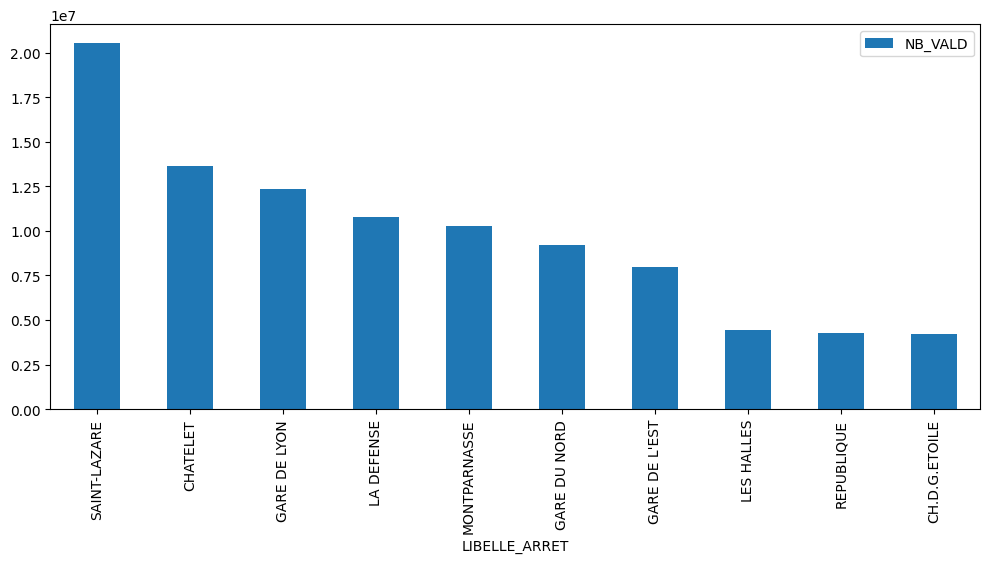

In [28]:
traffic_rf.head(10).plot(
    kind="bar",
    x="LIBELLE_ARRET",
    y="NB_VALD",
    figsize=(12,5)
)

On trouve que les stations les plus fréquentées sont les grandes gares parisiennes, et d'autres stations qui sont des noeuds comme Châtelet ou La Défense.

Construction de la liste des stations avec coordonnées GPS

In [29]:
# 0. Lecture des GTFS
stops = pd.read_csv("data/gtfs/stops.txt")
routes = pd.read_csv("data/gtfs/routes.txt")
trips = pd.read_csv("data/gtfs/trips.txt")
stop_times = pd.read_parquet("data/gtfs/stop_times.parquet")

# 1. Associer stop_id et route_type
routes_small = routes[["route_id", "route_type"]]
trips_small = trips[["trip_id", "route_id"]]
stop_times_small = stop_times[["trip_id", "stop_id"]]

stop_trip = stop_times_small.merge(trips_small, on="trip_id", how="left")
stop_route = stop_trip.merge(routes_small, on="route_id", how="left")

stop_route = stop_route[["stop_id", "route_type"]].drop_duplicates()

# 2. Sélectionner les stations
rail_like_types = [1, 2] #métro, train
stop_rail = stop_route[stop_route["route_type"].isin(rail_like_types)]

stops_rail = stops.merge(
    stop_rail[["stop_id"]].drop_duplicates(),
    on="stop_id",
    how="inner"
)

# 3. Regrouper les quais : utiliser parent_station
stops_rail["station_id"] = stops_rail["parent_station"].fillna(stops_rail["stop_id"])

stations = (
    stops_rail
    .groupby("station_id", as_index=False)
    .agg({
        "stop_name": "first",
        "stop_lon": "mean",
        "stop_lat": "mean"
    })
)

# 4. Passage en GeoDataFrame pour l'analyse
CRS_WGS84 = "EPSG:4326"
CRS_LAMBERT93 = "EPSG:2154"

stations_gdf = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations["stop_lon"], stations["stop_lat"]),
    crs=CRS_WGS84
)

stations_proj_rf = stations_gdf.to_crs(CRS_LAMBERT93)
stations_proj_rf = stations_proj_rf.rename(columns={"stop_name": "station_name"})

/tmp/ipykernel_231222/3816008650.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv("data/gtfs/trips.txt")


Merge des coordonnées GPS sur les validations

In [30]:
#Les clés uniques des stations ne sont pas exactement les mêmes dans les données de validations et les données GTFS
traffic_rf["ID_ZDC"] = traffic_rf["ID_ZDC"].astype(int)
traffic_rf["stop_id"] = "IDFM:" + traffic_rf["ID_ZDC"].astype(str)

stations_vald_rf = stations_proj_rf.merge(traffic_rf,left_on = "station_id",right_on="stop_id",how="inner")
#le inner permet d'exclure les gares non-présentes dans les validations
stations_vald_rf = stations_vald_rf[["station_id","station_name","stop_lon","stop_lat","geometry","NB_VALD"]]

Construction d'une carte avec des cercles proportionnels au nombre de validations dans la station

In [31]:
df = stations_vald_rf.copy()

# Vérifier que les colonnes lat/lon sont bien float
df['stop_lat'] = df['stop_lat'].astype(float)
df['stop_lon'] = df['stop_lon'].astype(float)
df['NB_VALD'] = df['NB_VALD'].astype(float)

# Normaliser rayon pour la visualisation
max_radius = 30
df['radius'] = df['NB_VALD'] / df['NB_VALD'].max() * max_radius
df['radius'] = df['radius'].clip(lower=2)  # pour que même les petites valeurs soient visibles

# Création de la carte
m = folium.Map(location=[48.85, 2.35], zoom_start=12)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=row['radius'],
        color='red',
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['station_name']}: {int(row['NB_VALD']):,} validations"
    ).add_to(m)

# Ajuster la vue pour inclure tous les points
m.fit_bounds(df[['stop_lat','stop_lon']].values.tolist())

# Affichage de la carte
m  

On retrouve bien les stations les plus fréquentées : Saint-Lazare, Châtelet, La Défense, Montparnasse, Gare de Lyon, Gare du Nord... Globalement toutes les stations les plus fréquentées sont situées dans Paris, sauf La Défense.

Ainsi, notre première théorie pour justifier la fréquentation d'une station semble être vérifiée au vu de cette première carte. Regardons si nous pouvons confirmer cela.
Nous allons observer la corrélation entre le nombre de lignes passant par une station et sa fréquentation

Premièrement, regardons les stations ayant le plus grand nombre de lignes :

In [32]:
# Filtrer réseau ferré
rail_routes = routes[routes["route_type"].isin([1, 2])]  # 1=Métro, 2=Train/RER
print(f" Nombre de lignes ferrées détectées : {rail_routes.shape[0]}")

# stop_id -> trip -> route
stop_trip = stop_times.merge(trips[["trip_id", "route_id"]], on="trip_id", how="left")
stop_trip_route = stop_trip.merge(rail_routes[["route_id", "route_short_name"]], on="route_id", how="inner")

# Regroupement station physique via parent_station 
stops["station_id"] = stops["parent_station"].fillna(stops["stop_id"])
stop_trip_route = stop_trip_route.merge(stops[["stop_id", "station_id"]], on="stop_id", how="left")

# Nombre de lignes uniques par station ferrée
station_lignes = (
    stop_trip_route.groupby("station_id")["route_short_name"]
    .nunique()
    .reset_index()
    .rename(columns={"route_short_name": "nb_lignes_fer"})
)
# Fusion avec validations 
df_nb_lignes = stations_vald_rf.merge(station_lignes, on="station_id", how="left")
df_nb_lignes = df_nb_lignes.drop_duplicates(subset=["station_id"], keep="first")

df_nb_lignes.sort_values(by="nb_lignes_fer",ascending=False).head(10)

 Nombre de lignes ferrées détectées : 41


station_id          station_name  stop_lon   stop_lat  \
507  IDFM:71410          Gare du Nord  2.356966  48.880158   
498  IDFM:71370     Gare Saint-Lazare  2.325168  48.876032   
417  IDFM:71139     Gare Montparnasse  2.321473  48.842169   
691  IDFM:73626          Gare de Lyon  2.373654  48.844754   
494  IDFM:71359         Gare de l'Est  2.358512  48.876850   
561  IDFM:71673                Nation  2.395872  48.848338   
456  IDFM:71264              Châtelet  2.346952  48.858625   
528  IDFM:71517            La Défense  2.238255  48.892014   
474  IDFM:71311            République  2.363942  48.867539   
147  IDFM:63880  Versailles Chantiers  2.134980  48.795115   

                           geometry     NB_VALD  nb_lignes_fer  
507   POINT (652840.05 6864651.895)   9182447.0              7  
498  POINT (650504.147 6864212.594)  20559184.0              7  
417  POINT (650200.773 6860449.646)  10255590.0              6  
691  POINT (654032.649 6860705.399)  12328284.0              6  
494  POINT (652950.444 6864283.125)   7987855.0              6  
561  POINT (655666.304 6861091.222)   3466761.0              5  
456     POINT (652085.82 6862263.6)  13665229.0              5  
528  POINT (644146.767 6866047.667)  10767994.0              5  
474   POINT (653340.359 6863244.55)   4296079.0              5  
147  POINT (636456.625 6855351.733)   1611110.0              5

On retrouve plus ou moins les mêmes stations que précédemment, ce qui tend à vérifier l'hypothèse.

In [33]:
# Test de corrélation 
df_nb_lignes["NB_VALD"].corr(df_nb_lignes["nb_lignes_fer"])

np.float64(0.7137803488331276)

On obtient une corrélation forte (>0.7)

Visualisons plus précisément le lien entre nombre de lignes et validations :

**Boxplot :**

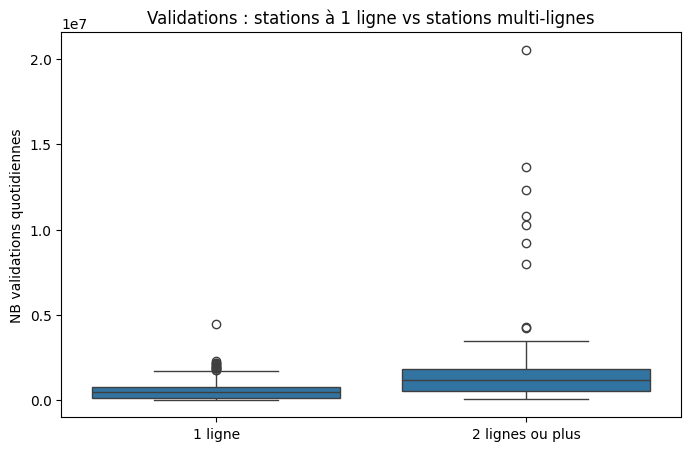

Médiane 1 seule ligne : 433274.0
Médiane multilignes : 1175881.0


In [34]:
# Boxplot

df_nb_lignes["multi"] = df_nb_lignes["nb_lignes_fer"].apply(lambda x: "1 ligne" if x==1 else "2 lignes ou plus")

# 1 ligne VS Multilignes
plt.figure(figsize=(8,5))
sns.boxplot(data=df_nb_lignes, x="multi", y="NB_VALD")
plt.title("Validations : stations à 1 ligne vs stations multi-lignes")
plt.ylabel("NB validations quotidiennes")
plt.xlabel("")
plt.show()

print("Médiane 1 seule ligne :",df_nb_lignes[df_nb_lignes["multi"] == "1 ligne"]["NB_VALD"].median())
print("Médiane multilignes :",df_nb_lignes[df_nb_lignes["multi"] == "2 lignes ou plus"]["NB_VALD"].median())

On constate que la médiane des stations à plusieurs lignes est quasiment 3 fois plus grande que celle des stations à une seule ligne. L'hypothèse est vraisemblable.

**Nuage de points :** 

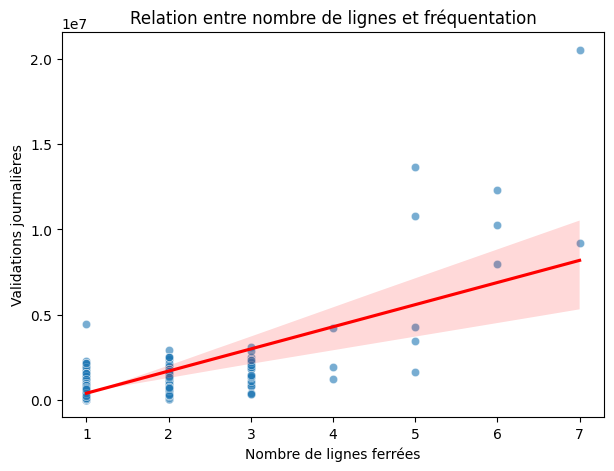

In [35]:
# Nuage de points
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_nb_lignes, x="nb_lignes_fer", y="NB_VALD", alpha=0.6)
sns.regplot(data=df_nb_lignes, x="nb_lignes_fer", y="NB_VALD", scatter=False, color="red")
plt.title("Relation entre nombre de lignes et fréquentation")
plt.xlabel("Nombre de lignes ferrées")
plt.ylabel("Validations journalières")
plt.show()

On observe bien qu'en moyenne : plus il y a de lignes qui passent dans une station, plus elle est fréquentée. Mais il ne semble pas y avoir de relation linéaire, certains points sont très éloignés de la droite rouge.

**Fréquentation moyenne par nombre de lignes :**

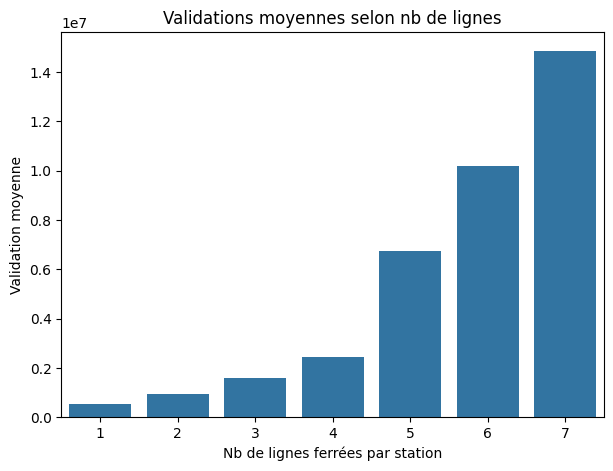

In [36]:
df_group = df_nb_lignes.groupby("nb_lignes_fer")["NB_VALD"].mean().reset_index()

plt.figure(figsize=(7,5))
sns.barplot(data=df_group, x="nb_lignes_fer", y="NB_VALD")
plt.title("Validations moyennes selon nb de lignes")
plt.xlabel("Nb de lignes ferrées par station")
plt.ylabel("Validation moyenne")
plt.show()

Sur ce diagramme en bâton, on constate clairement que le nombre de validations augmente avec le nombre de lignes.

**Conclusion de l'hypothèse 1 : les résultats confirment que les noeuds du réseau sont très fréquentés.**

### II. 2. Visualisation des POI récupérés

Dans cette deuxième partie, nous allons nous intéresser à l'hypothèse selon laquelle **un environnement urbain dense favorise la fréquentation d'une station**

Dans un premier temps, nous créons un dataframe contenant pour chaque station, le nombre de POI (par catégorie) dans un rayon de 500m.

In [37]:
stations_gdf = stations_gdf.rename(columns={"stop_name":"station_name"}) #on reprend le GeoDataFrame
# stations_gdf doit être en Lambert 93 (EPSG:2154)
stations_proj_rf = stations_gdf.to_crs(CRS_LAMBERT93)

def poi_autour(path, rayon=500):
    """
    Compte le nombre de POI autour de chaque station dans un rayon donné (en mètres).
    """
    gdf = gpd.read_parquet(path)
    
    # Assurer que le CRS est correct
    if gdf.crs is None or gdf.crs.to_string() != "EPSG:2154":
        gdf = gdf.set_crs("EPSG:4326", allow_override=True).to_crs("EPSG:2154")
    
    # Créer buffer autour des stations
    buffers = stations_proj_rf[["station_id", "geometry"]].copy()
    buffers["geometry"] = buffers.geometry.buffer(rayon)
    
    # Jointure spatiale : POI à l'intérieur du buffer
    hits = gpd.sjoin(gdf[["geometry"]], buffers, how="inner", predicate="within")
    
    # Comptage par station
    poi_par_station = (
        hits.groupby("station_id")
        .size()
        .reset_index()
        .rename(columns={0: "nb_poi"})
    )
    return poi_par_station

poi_categories = [
    "poi_commerce_proximite",
    "poi_commerce_majeur",
    "poi_education2",
    "poi_sante2",
    "poi_culture",
    "poi_logement",
    "poi_bureaux2",
    "poi_restaurants",
    "poi_administration2",
    "poi_sports_loisirs"
]

def tableau_poi_global(rayon=500):
    """
    Agrège tous les POI autour des stations pour toutes les catégories.
    Retourne un DataFrame pandas avec station_id et nb_poi par catégorie.
    """
    resultat = None

    for cat in poi_categories:
        print(f"Traitement de la catégorie : {cat}")
        
        gdf_cat = poi_autour("data/poi/" + cat + ".parquet", rayon)
        gdf_cat = gdf_cat.rename(columns={"nb_poi": f"{cat}"})
        
        if resultat is None:
            resultat = gdf_cat
        else:
            # Merge uniquement sur station_id pour éviter conflit avec station_name
            resultat = resultat.merge(gdf_cat, on="station_id", how="outer")
    
    # Remplacer les NaN par 0
    resultat = resultat.fillna(0)
    
    return resultat

In [38]:
df_poi = tableau_poi_global(rayon=500)

# Fusion avec les validations
df_final = stations_vald_rf.merge(df_poi, on="station_id", how="left")
df_final.fillna(0, inplace=True)
df_final.head(3)

Traitement de la catégorie : poi_commerce_proximite
Traitement de la catégorie : poi_commerce_majeur
Traitement de la catégorie : poi_education2
Traitement de la catégorie : poi_sante2
Traitement de la catégorie : poi_culture
Traitement de la catégorie : poi_logement
Traitement de la catégorie : poi_bureaux2
Traitement de la catégorie : poi_restaurants
Traitement de la catégorie : poi_administration2
Traitement de la catégorie : poi_sports_loisirs


station_id                 station_name  stop_lon   stop_lat  \
0  IDFM:412687                      Pernety  2.318359  48.834121   
1  IDFM:412697  Noisy-le-Grand - Mont d'Est  2.550027  48.840885   
2  IDFM:412992                    Boucicaut  2.287856  48.841073   

                       geometry    NB_VALD  poi_commerce_proximite  \
0  POINT (649964.47 6859556.75)   708730.0                   105.0   
1        POINT (666974 6860187)  2109880.0                    24.0   
2    POINT (647732.5 6860349.5)   789365.0                    68.0   

   poi_commerce_majeur  poi_education2  poi_sante2  poi_culture  poi_logement  \
0                  0.0            29.0         6.0          1.0         984.0   
1                  1.0            13.0         1.0          1.0          15.0   
2                  0.0            26.0         4.0          2.0         369.0   

   poi_bureaux2  poi_restaurants  poi_administration2  poi_sports_loisirs  
0          20.0            102.0                  3.0                18.0  
1           5.0             13.0                  1.0                 4.0  
2           9.0             66.0                  3.0                10.0

Ensuite, nous souhaitons observer les corrélations entre les POI et le nombre de validations (fréquentation), mais aussi entre les POI eux même afin de sélectionner les plus utiles.

Visualisation de la matrice de corrélation :

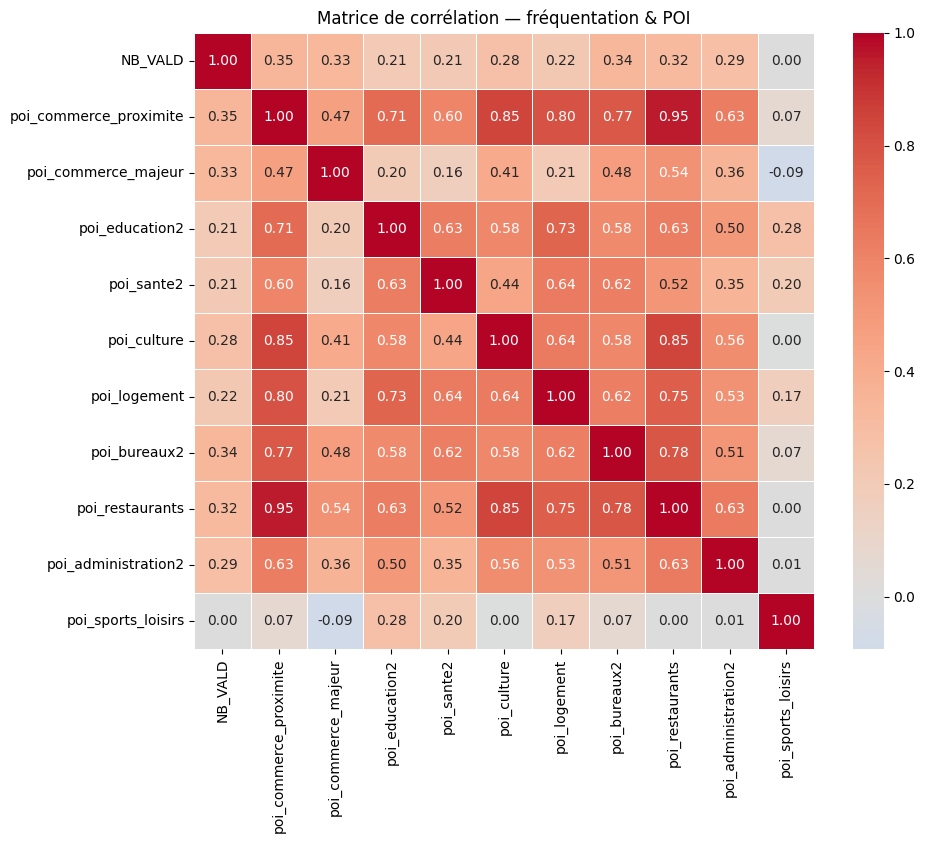

In [39]:
df_numerique = df_final[["NB_VALD",
    "poi_commerce_proximite",
    "poi_commerce_majeur",
    "poi_education2",
    "poi_sante2",
    "poi_culture",
    "poi_logement",
    "poi_bureaux2",
    "poi_restaurants",
    "poi_administration2",
    "poi_sports_loisirs"]]
    
# Heatmap
corr = df_numerique.corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    annot=True,          # valeurs écrites
    cmap="coolwarm",     # palette lisible
    center=0,            # neutre = pas de lien
    linewidths=.7,       # séparation visuelle
    fmt=".2f"            # arrondi lisible
)
plt.title("Matrice de corrélation — fréquentation & POI")
plt.show()


On observe une corrélation forte entre restaurants, logement et commerce_proximité. Cela s'explique par le fait qu'ils s'articulent ensemble. En effet, lorsqu'il y a beaucoup de logements, il faut davantage de commerces de proximité et de restaurants dans cette même zone. Néanmoins, si la présence de nombreux logement justifie une forte fréquentation des stations, les restaurants et commerces de proximités en sont plutôt une conséquence. Mais les commerces de proximité ont une corrélation avec les validations bien plus élevée que celle des logements, donc pour la suite, on ne gardera que commerce_proximite.

On enlève également sports_loisirs qui ne semble pas avoir de lien avec validations. Une hypothèse qui peut justifier cela est que les différentes installations sportives n'ont pas du tout les mêmes attractivités.

A présent, nous allons créer une variable "poi_attractivite" qui somme les POI que nous conservons, elle permet d'agréger les POI pour une analyse globale. On normalise en divisant chaque élément par le maximum de sa colonne pour qu'ils aient tous le même ordre de grandeur.

In [40]:
df_final["poi_attractivite_norm"] = (df_final["poi_commerce_majeur"]/13
+ df_final["poi_education2"]/51
+ df_final["poi_sante2"]/37
+ df_final["poi_culture"]/29
+ df_final["poi_bureaux2"]/61
+ df_final["poi_administration2"]/11 
+ df_final["poi_commerce_proximite"]/471 
)

df_final["NB_VALD"].corr(df_final["poi_attractivite_norm"])

np.float64(0.36373437204331255)

Visualisons sur une carte la présence des POI par rapport à la fréquentation :

In [41]:
#carte des poi, à superposer avec la carte des stations
#cercles bleus, leur taille dépend du nombre de poi total. Superposer avec cercles rouges

df = df_final.copy()

# Normalisation rayon validations
df["radius_vald"] = (df["NB_VALD"] / df["NB_VALD"].max() * 30).clip(lower=2)

# Normalisation rayon POI attractivité
df["radius_poi"] = (df["poi_attractivite_norm"] / df["poi_attractivite_norm"].max() * 30).clip(lower=2)

# Carte
m = folium.Map(location=[48.85, 2.35], zoom_start=12)

# Cercles validations en rouge
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["stop_lat"], row["stop_lon"]],
        radius=row["radius_vald"],
        color="red",
        fill=True,
        fill_opacity=0.4,
        popup=f"{row['station_name']}<br>Validations : {int(row['NB_VALD']):,}"
    ).add_to(m)

# Cercles attractivité POI en bleu
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["stop_lat"], row["stop_lon"]],
        radius=row["radius_poi"],
        color="blue",
        fill=True,
        fill_opacity=0.35,
        popup=f"{row['station_name']}<br>Attractivité POI : {row['poi_attractivite_norm']:.2f}"
    ).add_to(m)

# Ajuste la vue
m.fit_bounds(df[['stop_lat','stop_lon']].values.tolist())

m

Dans cette partie nous avons constaté une corrélation positive entre la présence de POI et la fréquentation, mais elle n'est pas très importante. Quelques hypothèses pour expliquer cela :

- Certaines stations très fréquentées (Gare du Nord, Châtelet, Saint-Lazare, etc.) concentrent un nombre élevé de validations sans pour autant présenter un volume proportionnel de points d’intérêt à proximité immédiate. Cela tient notamment au fait que notre mesure n’intègre pas la gare elle-même comme POI, alors qu’il s’agit d’un attracteur majeur.

- Les stations « hub » génèrent des valeurs très élevées qui peuvent influencer visuellement et statistiquement les résultats (effet d’outliers).

Une piste pour aller plus loin consiste à examiner la relation via une régression linéaire, ce qui est traité dans la partie Modélisation.

### II. 3. Offre de transport

Dans cette dernière partie d'analyse et visualisation, nous allons explorer la piste de notre dernière hypothèse concernant l'effet de la **qualité de service**. 

Nous cherchons ici à mesurer si l’offre de transport est corrélée à la fréquentation observée. Nous calculons le nombre de trains qui passent en heure de pointe du matin sur un jour de semaine jugé représentatif.

In [ ]:
gtfs_dir = "data/gtfs"
gtfs_dir = Path(gtfs_dir)

calendar = pd.read_csv(gtfs_dir / "calendar.txt")
trips = pd.read_csv(gtfs_dir / "trips.txt")
stop_times = pd.read_parquet(gtfs_dir / "stop_times.parquet")
stops = pd.read_csv(gtfs_dir / "stops.txt")
calendar_dates = pd.read_csv(gtfs_dir / "calendar_dates.txt")
routes = pd.read_csv(gtfs_dir / "routes.txt")

# Trouver automatiquement un lundi hors vacances de Noël

calendar_tmp = calendar.copy()

# Convertir les dates GTFS en datetime
calendar_tmp["start_date_dt"] = pd.to_datetime(calendar_tmp["start_date"], format="%Y%m%d")
calendar_tmp["end_date_dt"]   = pd.to_datetime(calendar_tmp["end_date"],   format="%Y%m%d")

candidates = []

for _, row in calendar_tmp.iterrows():
    if row["monday"] != 1:
        continue

    # Générer tous les lundis dans l'intervalle de validité
    lundis = pd.date_range(
        start=row["start_date_dt"],
        end=row["end_date_dt"],
        freq="W-MON"
    )

    for d in lundis:
        # Exclure vacances de Noël
        if not (
            (d.month == 12 and d.day >= 20) or
            (d.month == 1  and d.day <= 4)
        ):
            candidates.append(d)

candidates = list(set(candidates)) # on drop les doublons
candidates = sorted(candidates)
date = candidates[-1] # on prend le lundi le plus loin
print("Date retenue pour l'analyse :", date.date())

dint = int(date.strftime("%Y%m%d"))

/tmp/ipykernel_231222/1608489781.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv(gtfs_dir / "trips.txt")


Date retenue pour l'analyse : 2026-01-12


In [43]:
# Déterminer les service_id actifs

active = calendar[
    (calendar["start_date"] <= dint) &
    (calendar["end_date"]   >= dint) &
    (calendar["monday"] == 1)
]["service_id"]

# Exceptions (ajouts/suppressions) ce jour-là
exc = calendar_dates[calendar_dates["date"] == dint]
to_remove = set(exc.loc[exc["exception_type"] == 2, "service_id"])
to_add    = set(exc.loc[exc["exception_type"] == 1, "service_id"])

active = set(active) - to_remove
active |= to_add

# Harmoniser types
trips["service_id"] = trips["service_id"].astype(str)
active_ids = pd.Index(sorted(map(str, active)))

# Filtrer l’offre ferroviaire (route_type) et les trips actifs
rail_routes = routes[routes["route_type"].isin([2,1])] # train=2, métro=1
trips_day = trips[trips["service_id"].isin(active_ids) &
                  trips["route_id"].isin(rail_routes["route_id"])]

# Lier aux stop_times et calculer l’heure de passage
# On compte un passage par (trip_id, stop_id) : distinct trip_id à un stop
# Utilise arrival_time OU departure_time (une seule, pour ne pas double-compter).

st = stop_times[stop_times["trip_id"].isin(trips_day["trip_id"])].copy()

# Conversion robuste HH:MM:SS -> minutes, en gérant >24:00:00
def to_min(t):
    if not isinstance(t, str) or t.count(":") != 2:
        return None
    h, m, s = map(int, t.split(":"))
    return h*60 + m + s/60

# Choix de la colonne temps (arrival_time conseillé pour "passage")
st["t_min"] = st["arrival_time"].map(to_min)

# Filtrer la fenêtre 07:00–10:00
mask_window = (st["t_min"] >= 7*60) & (st["t_min"] < 10*60)
st_peak = st.loc[mask_window, ["trip_id","stop_id"]].dropna()

# Compter les trains par station
# N.B. on compte des trips DISTINCTS par stop_id pour éviter les doublons.
trains_par_station = (st_peak.drop_duplicates(["trip_id","stop_id"])
                            .groupby("stop_id", as_index=False)
                            .size()
                            .rename(columns={"size":"trains_7_10"}))

# Joindre les libellés (stop_name) et parent_station 
stops_small = stops[["stop_id","stop_name","parent_station"]].copy()
res = trains_par_station.merge(stops_small, on="stop_id", how="left")

# Agréger au niveau "station" (parent_station) si les quais sont séparés pour avoir une ligne par vraie station
if "parent_station" in stops.columns and stops["parent_station"].notna().any():
    res_station = (res.assign(parent_station=res["parent_station"].fillna(res["stop_id"]))
                     .groupby("parent_station", as_index=False)["trains_7_10"].sum()
                     .merge(stops[["stop_id","stop_name"]], left_on="parent_station", right_on="stop_id", how="left")
                     .rename(columns={"stop_name":"station_name"})
                     .drop(columns=["stop_id"]))
    # res_station : trains par "station" (groupé)

res_station = res_station.sort_values(by="trains_7_10",ascending=False)
res_station.head(10)

parent_station  trains_7_10                station_name
537     IDFM:71370          982           Gare Saint-Lazare
495     IDFM:71264          920                    Châtelet
513     IDFM:71311          857                  République
594     IDFM:71673          837                      Nation
456     IDFM:71139          763           Gare Montparnasse
528     IDFM:71347          665  Charles de Gaulle - Etoile
545     IDFM:71410          663                Gare du Nord
721     IDFM:73626          626                Gare de Lyon
533     IDFM:71359          596               Gare de l'Est
427     IDFM:71033          534              Place d'Italie

Nous retrouvons les mêmes stations majeures, ici nous avons près de 1000 trains passant par Saint Lazare en heure de pointe du matin (7h-10h). 

Les chiffres peuvent varier si on télécharge de nouveau le GTFS car il est mis à jour plusieurs fois par jour.

**Visualisation** : Carte avec des cercles proportionnels au nombre de trains entre 7h et 10h.

In [44]:
df_map = res_station.merge(stops, left_on="parent_station", right_on="stop_id", how="left")

# Normalisation du rayon
max_radius = 25
df_map["radius"] = df_map["trains_7_10"] / df_map["trains_7_10"].max() * max_radius
df_map["radius"] = df_map["radius"].clip(lower=2)

m = folium.Map(location=[48.85, 2.35], zoom_start=12)

for _, row in df_map.iterrows():
    folium.CircleMarker(
        location=[row["stop_lat"], row["stop_lon"]],
        radius=row["radius"],
        color="darkblue",
        fill=True,
        fill_opacity=0.45,
        popup=f"{row['station_name']} — {row['trains_7_10']} trains (7h-10h)"
    ).add_to(m)

m.fit_bounds(df_map[['stop_lat','stop_lon']].values.tolist())
m

Barplot du top 20 des stations avec le plus de trains en heure de pointe

/tmp/ipykernel_231222/1163282587.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top20, y="station_name", x="trains_7_10", palette="Blues_r")


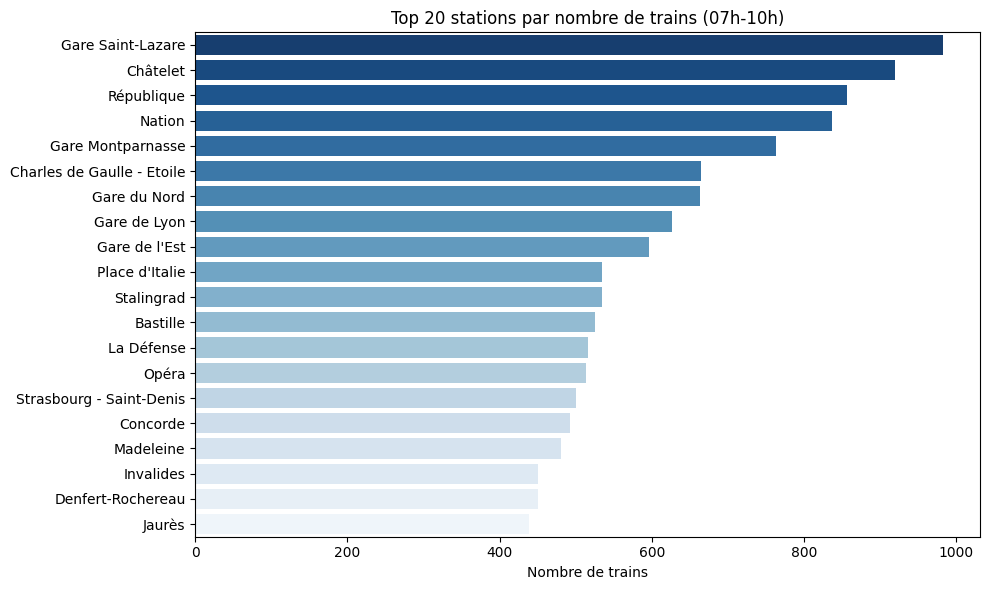

In [45]:
top20 = res_station.sort_values("trains_7_10", ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=top20, y="station_name", x="trains_7_10", palette="Blues_r")
plt.title("Top 20 stations par nombre de trains (07h-10h)")
plt.xlabel("Nombre de trains")
plt.ylabel("")
plt.tight_layout()
plt.show()


On retrouve logiquement les grands nœuds du réseau, car les stations les plus fréquentées nécessitent une offre plus dense.
On observe également que certaines stations de métro, notamment République, desservie par cinq lignes, apparaissent très haut dans le classement malgré une fréquentation plus modérée, ce qui reflète la fréquence particulièrement élevée du métro par rapport au RER.

Nous pouvons regarder la corrélation entre la fréquentation (nb_vald) et le nombre de train

In [46]:
df_offre_vald = df_final.merge(res_station,left_on = "station_id", right_on = "parent_station", how="left")
df_offre_vald["NB_VALD"].corr(df_offre_vald["trains_7_10"])

np.float64(0.7120233458648936)

On obtient une corrélation à 0.7 ce qui confirme notre dernière observation.

Visualisation : Scatterplot validations vs. nombre de trains (corrélation)

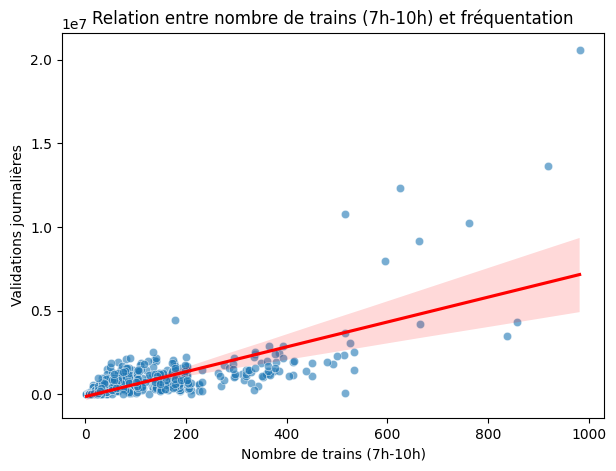

In [47]:
df_plot = df_final.merge(res_station, left_on="station_id", right_on="parent_station", how="left")

plt.figure(figsize=(7,5))
sns.scatterplot(data=df_plot, x="trains_7_10", y="NB_VALD", alpha=0.6)
sns.regplot(data=df_plot, x="trains_7_10", y="NB_VALD", scatter=False, color="red")
plt.title("Relation entre nombre de trains (7h-10h) et fréquentation")
plt.xlabel("Nombre de trains (7h-10h)")
plt.ylabel("Validations journalières")
plt.show()


Interprétation  : 
- La pente est positive : plus il y a de trains, plus la fréquentation est élevée ce qui est normal, l’offre suit la demande.
- Nous avons un certain nombre de points proches de la ligne, ce sont les stations où l’offre est proportionnelle à la fréquentation.
- Il y a également des points éloignés de la ligne, ce sont les stations atypiques / outliers (ex. grandes gares, stations touristiques...)

Concernant les outliers, cela peut être : 
- Des stations avec beaucoup de trains mais peu de validations : souvent des noeuds où peu de voyageurs montent (correspondances).
- Des stations avec "peu" de trains mais beaucoup de validations : stations avec forte demande ponctuelle.

**Conclusion de l'hypothèse sur la qualité de service :**

La fréquentation des stations augmente globalement avec le nombre de trains le matin, comme le montre la corrélation de 0.7. Cependant, certaines stations, notamment les grands hubs, s’écartent de cette tendance, ce qui reflète l’effet d’outliers et des caractéristiques locales spécifiques (tourisme, correspondances, POI). 

Par ailleurs, la corrélation ne prouve pas la causalité : ce n’est pas parce qu’on met plus de trains qu’il y aura plus de validations. Néanmoins, cette analyse est utile pour vérifier la cohérence de l’offre par rapport à la demande et peut aider à identifier des stations sous- ou sur-desservies.

## III. Modélisation

### III. 1. Régression linéaire des validations sur l’attractivité POI (approfondissement de l'hypothèse 2)

Comme évoqué en fin de partie II.2) nous allons faire une régression linéaire du nombre de validations sur l’attractivité POI :

In [48]:
df_final["maj_norm"] = df_final["poi_commerce_majeur"]/13

df_final["educ_norm"] = df_final["poi_education2"]/51

df_final["sante_norm"] = df_final["poi_sante2"]/37

df_final["cult_norm"] = df_final["poi_culture"]/29

df_final["bur_norm"] = df_final["poi_bureaux2"]/61

df_final["admin_norm"] = df_final["poi_administration2"]/11 

df_final["log_norm"] = df_final["poi_logement"]/1311

df_final["prox_norm"] = df_final["poi_commerce_proximite"]/471

X = df_final[["maj_norm","educ_norm","sante_norm","cult_norm","bur_norm","admin_norm","prox_norm","log_norm"]]

y = df_final["NB_VALD"]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                NB_VALD   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     18.81
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           8.73e-26
Time:                        16:01:59   Log-Likelihood:                -11341.
No. Observations:                 735   AIC:                         2.270e+04
Df Residuals:                     726   BIC:                         2.274e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.361e+05   7.49e+04      4.489      0.0

Pour la suite :

On retire educ, sante et culture car ils ne sont pas significatifs (p-valeur trop grandes) donc ont peu de pouvoir explicatif à l'échelle des stations étudiées.

En revanche, on conserve commerce majeur, administration et bureaux qui représentent les flux réguliers attendus.

On garde commerce proximité et on supprime logement, car les deux sont très corrélés donc cela suffira pour garder l'effet densité résidentielle.

Regardons maintenant une régression avec log(NB_VALD) pour mieux cibler l'effet des poi et en limitant la multicolinéarité.

In [49]:
X = df_final[["maj_norm","bur_norm","admin_norm","prox_norm"]] #on ne garde que les variables qui étaient significatives
X = sm.add_constant(X)
y_log = np.log(df_final["NB_VALD"])

# On ne met que y en log ici car on a normalisé les poi, donc les variables ont déjà des échelles comparables
# Et on met en log pour y pour faciliter l'interprétation

model_log = sm.OLS(y_log, X).fit()
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:                NB_VALD   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     62.02
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           3.98e-45
Time:                        16:01:59   Log-Likelihood:                -1298.5
No. Observations:                 735   AIC:                             2607.
Df Residuals:                     730   BIC:                             2630.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.8195      0.080    148.642      0.0

Commerce de proximité : coefficient significatif de 1.3 /
Une augmentation de 1 % de la densité de commerce de proximité autour d’une station est associée à une hausse d’environ 1.3 % des validations journalières.

Bureaux : coefficient significatif de 3.2 /
Une augmentation de 1 % de la densité de bureaux est associée à une hausse d’environ 3.2 % de la fréquentation. C'est un effet plus fort que le logement. Cela correspond bien à la logique des flux pendulaires et confirme le rôle des pôles d’emploi.

Administrations : coefficient significatif de 1.7 /
Une augmentation de 1 % de la densité d'administrations est associée à une hausse d’environ 1.7 % de la fréquentation. Les administrations ont un effet réel mais plus localisé.

Commerces majeurs : coefficient non-significatif /
Son effet est probablement capté par les bureaux et administrations ou très concentré sur quelques hubs (Châtelet, Opéra…). Les commerces majeurs jouent surtout un rôle de polarisation ponctuelle, plus difficile à capter par un modèle global.

**Conclusion sur l'hypothèse 2** : la fréquentation des stations est surtout sensible aux poi liés au travail et à l'habitat, tandis que d'autres types de poi (éducation, culture, santé) n'apparaissent pas comme déterminants dans ce modèle.

### III. 2. Régression des validations sur le nombre de trains (approfondissement de l'hypothèse 3)

On fait une régression log-log :

In [50]:
df = df_offre_vald.copy()

# remplacer inf / -inf par NaN
df_clean = df.replace([np.inf, -np.inf], np.nan)

# supprimer toutes les lignes contenant un NaN
df_clean = df_clean.dropna()

y = df_clean["NB_VALD"]
y_log = np.log(df_clean["NB_VALD"])
X = df_clean[["trains_7_10"]]
X_log = np.log(df_clean[["trains_7_10"]])
X = sm.add_constant(X)

model = sm.OLS(y_log, X_log).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                NB_VALD   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                          2.058e+04
Date:                Fri, 19 Dec 2025   Prob (F-statistic):                        0.00
Time:                        16:01:59   Log-Likelihood:                         -1672.0
No. Observations:                 734   AIC:                                      3346.
Df Residuals:                     733   BIC:                                      3351.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

Une augmentation de l'offre de transport de 1% est associée à une hausse de 2.9% des validations. Le R² est très élevé : le modèle explique 96% de la variance des validations à partir du nombre de trains. Le coefficient est bien significatif (p-valeur très petite).

**Conclusion de H3 :** La qualité de service est très fortement corrélée avec le nombre de validations. 

## IV. Limites du projet 

### IV. 1. Limites des données de validations

Les données de validations, comme leur nom l'indique, mesurent le nombre de personnes qui ont validé un titre de transport dans une station. Ainsi, cela prend en compte uniquement les entrées et pas les sorties. Dans la plupart des cas cela n'a pas grande importance car on peut supposer qu'il y a à peu près autant d'entrées que de sorties dans une station (car les voyageurs font des allers-retours), mais illustrons tout de même cette limite avec un exemple :


In [51]:
df_metro = df_rf[df_rf["code_stif_res"] == "110"] #on sélectionne les stations de métro
traffic_metro = df_metro.groupby(["ID_ZDC", "LIBELLE_ARRET"])["NB_VALD"].sum().reset_index().sort_values("NB_VALD", ascending=True)
traffic_metro.head(10)

ID_ZDC   LIBELLE_ARRET   NB_VALD
74   71166.0  EGLI.D'AUTEUIL   42277.0
210  71828.0       PELLEPORT   73113.0
225  71911.0  PRE-ST-GERVAIS   94174.0
222  71900.0   BUTTES-CHAUM.  109472.0
226  71920.0         BOLIVAR  129784.0
227  71930.0          DANUBE  133791.0
214  71860.0   SAINT-FARGEAU  156165.0
63   71141.0  CHARDON-LAGACH  173759.0
76   71169.0   PTE D'AUTEUIL  175211.0
272  73641.0       FALGUIERE  210605.0

On observe que la station de métro la moins fréquentée d'Ile de France (d'assez loin en plus) est Eglise d'Auteuil, située dans le 16e arrondissement sur la ligne 10. Alors même que selon des chiffres d'IDFM, la ligne 10 transporte près de 11 fois plus de voyageurs par an que les lignes 3 bis et 7 bis, dont les stations apparaissent juste après dans le classement (Pelleport, Pré Saint-Gervais...). Cela s'explique par le fait qu'Eglise d'Auteuil est une station où les voyageurs descendent beaucoup plus qu'ils ne montent, car la ligne 10 ne s'y arrête que dans un seul sens. On peut donc supposer que la fréquentation de la station Eglise d'Auteuil est bien supérieure à ce qu'on obtient dans nos données.

De la même façon, les données de validation ne donnent pas d'information sur les correspondances. Par exemple, à Châtelet - Les Halles, lorsqu'une personne fait une correspondance entre une ligne de RER et une ligne de métro (par exemple du RER B à la ligne 1), elle est amenée à passer par un portique, ce qui compte comme une validation. Par contre, en cas de correspondances entre 2 lignes de RER (par exemple du RER B au RER A), la personne change simplement de quai sans passer par un portique, et donc ce n'est pas compté dans les données de validations.

De plus, les validations ne prennent bien sûr pas en compte la fraude, qui peut sensiblement varier selon la zone géographique.

Enfin, même si le ticket en carton est en train de disparaître en Ile de France, notons que les données de validation ne prennent en compte que les cartes Navigo (avec les différents forfaits), et pas les tickets en carton. On peut imaginer que cela impacte plus fortement certaines stations que d'autres, par exemple les stations touristiques avec une clientèle qui a davantage tendance à utiliser les tickets.

### IV. 2. Limites des noeuds

Ce n'est pas parce qu'une station voit passer beaucoup de lignes qu'elle est forcément un noeud à l'échelle du réseau entier :

In [52]:
df_nb_lignes.sort_values(by="nb_lignes_fer",ascending=False).head(10)

station_id          station_name  stop_lon   stop_lat  \
507  IDFM:71410          Gare du Nord  2.356966  48.880158   
498  IDFM:71370     Gare Saint-Lazare  2.325168  48.876032   
417  IDFM:71139     Gare Montparnasse  2.321473  48.842169   
691  IDFM:73626          Gare de Lyon  2.373654  48.844754   
494  IDFM:71359         Gare de l'Est  2.358512  48.876850   
561  IDFM:71673                Nation  2.395872  48.848338   
456  IDFM:71264              Châtelet  2.346952  48.858625   
528  IDFM:71517            La Défense  2.238255  48.892014   
474  IDFM:71311            République  2.363942  48.867539   
147  IDFM:63880  Versailles Chantiers  2.134980  48.795115   

                           geometry     NB_VALD  nb_lignes_fer  \
507   POINT (652840.05 6864651.895)   9182447.0              7   
498  POINT (650504.147 6864212.594)  20559184.0              7   
417  POINT (650200.773 6860449.646)  10255590.0              6   
691  POINT (654032.649 6860705.399)  12328284.0              6   
494  POINT (652950.444 6864283.125)   7987855.0              6   
561  POINT (655666.304 6861091.222)   3466761.0              5   
456     POINT (652085.82 6862263.6)  13665229.0              5   
528  POINT (644146.767 6866047.667)  10767994.0              5   
474   POINT (653340.359 6863244.55)   4296079.0              5   
147  POINT (636456.625 6855351.733)   1611110.0              5   

                multi  
507  2 lignes ou plus  
498  2 lignes ou plus  
417  2 lignes ou plus  
691  2 lignes ou plus  
494  2 lignes ou plus  
561  2 lignes ou plus  
456  2 lignes ou plus  
528  2 lignes ou plus  
474  2 lignes ou plus  
147  2 lignes ou plus

En reprenant les stations avec le plus de lignes, nous observons la présence de la gare de Versailles-Chantiers, avec 5 lignes. Certes, la gare de Versailles-Chantiers est effectivement desservie par 5 lignes différentes (RER C, transiliens N, U, V et ligne de TER), mais ces lignes n'ont pas une grande fréquentation. On peut qualifier la gare de Versailles-Chantiers de noeud car elle est située à l'intersection de plusieurs chemins de fer, mais ce n'est pas un noeud structurant.
Notons d'ailleurs que la gare de Versailles-Chantiers grimpera encore dans ce classement dans quelques années avec l'arrivée de la ligne 18 du Grand Paris Express. La fréquentation de cette gare augmentera sûrement, mais elle sera encore très loin de celles des noeuds structurants.

Pour répondre à cette limite, il faudrait donc prendre en compte la fréquentation des lignes qui passent à une station pour trouver uniquement des noeuds structurants. Une idée serait que le nombre de lignes d'une station soit une moyenne pondérée par des coefficients plus ou moins grands dépendant de la fréquentation de la ligne.

Cependant, notons que même ligne ne veut pas dire même desserte. C'est particulièrement vrai pour les lignes de transilien qui ont beaucoup de branches, avec certaines beaucoup plus fréquentées que d'autres et donc une offre très différente.

### IV. 3. Limites des POI

In [53]:
df_final.sort_values(by="poi_sports_loisirs",ascending=False).head(5)

station_id          station_name  stop_lon   stop_lat  \
111  IDFM:62172         Saint-Fargeau  2.542610  48.565026   
399  IDFM:71084  Porte de Saint-Cloud  2.256918  48.837978   
355  IDFM:70543              Gentilly  2.340927  48.815228   
179  IDFM:64949   Villennes-sur-Seine  1.999557  48.939831   
327  IDFM:69950     Créteil Pompadour  2.435316  48.771254   

                        geometry    NB_VALD  poi_commerce_proximite  \
111   POINT (666252 6829520.577)     5921.0                     0.0   
399  POINT (645458.6 6860026.25)  1215585.0                    47.0   
355     POINT (651603.5 6857442)   500667.0                    26.0   
179   POINT (626713 6871559.828)    57320.0                     4.0   
327     POINT (658499.5 6852499)   858869.0                     1.0   

     poi_commerce_majeur  poi_education2  poi_sante2  ...  poi_sports_loisirs  \
111                  0.0             0.0         0.0  ...                46.0   
399                  0.0            10.0         5.0  ...                42.0   
355                  0.0            11.0         1.0  ...                37.0   
179                  0.0             3.0         0.0  ...                33.0   
327                  0.0             0.0         0.0  ...                31.0   

     poi_attractivite_norm  maj_norm  educ_norm  sante_norm  cult_norm  \
111               0.000000       0.0   0.000000    0.000000   0.000000   
399               0.702238       0.0   0.196078    0.135135   0.000000   
355               0.383274       0.0   0.215686    0.027027   0.068966   
179               0.158225       0.0   0.058824    0.000000   0.000000   
327               0.002123       0.0   0.000000    0.000000   0.000000   

     bur_norm  admin_norm  log_norm  prox_norm  
111  0.000000    0.000000  0.023646   0.000000  
399  0.180328    0.090909  0.177727   0.099788  
355  0.016393    0.000000  0.428680   0.055202  
179  0.000000    0.090909  0.005339   0.008493  
327  0.000000    0.000000  0.000000   0.002123  

[5 rows x 25 columns]

On observe que la station ayant le plus de poi dans la catégorie sports et loisirs autour d'elle est Saint-Fargeau, une gare du RER D située en Seine-et-Marne. Il y a bien des infrastructures sportives près de cette gare, mais ces infrastructures ne génèrent pas tant de déplacements. Par exemple face au Parc des Princes (situé à côté de la station Porte de Saint-Cloud, deuxième de ce classement) où sont organisés régulièrement de grands évènements, comme des matchs de football ou des concerts.

De plus, dans notre modèle nous prenons le même rayon d'attractivité de 500 mètres pour toutes les stations. Or, on peut supposer que les stations situées au centre de Paris ont en réalité un rayon d'attractivité plus faible que les gares de banlieue, en raison de la densité du réseau. Nous avons exploré cette piste dans le notebook analyse.ipynb, disponible dans les traces de recherche. Cependant, cela n'a rien donné de mieux.

Une autre piste serait de mesurer la densité du réseau pour chaque station, par exemple en regardant à combien de mètres est située la k-ième station la plus proche de celle-ci.

## Conclusion

L’analyse des données de fréquentation et d’offre de transport en Île-de-France montre plusieurs enseignements principaux :

1. Relation entre fréquentation et topologie du réseau

- Les stations où passent plusieurs lignes ont une forte fréquentation.

2. Relation entre fréquentation et POI

- Les stations entourées de nombreux points d’intérêt (POI) tendent à avoir plus de validations, comme le suggère les régressions linéaires.

- La régression en log a précisé l'importance des poi d'habitat et d'emploi, et a marginalisé l'effet d'autres poi comme culture et education.

3. Relation entre fréquentation et offre de transport

- La corrélation quasi-parfaite entre le nombre de trains en heure de pointe et le nombre de validations.

- Certaines stations, comme les grands hubs (Gare du Nord, Châtelet), s’écartent de la tendance, révélant l’effet des outliers et les spécificités locales.


En résumé, la fréquentation des stations est fortement influencée à la fois par l’offre de transport et l’environnement immédiat (POI), mais certains hubs et outliers nécessitent une attention particulière. 